In [31]:
import numpy as np
import sympy
import qsymm
from qsymm.kwant_integration import builder_to_model
import kwant
import matplotlib.pyplot as plt

sympy.init_printing(print_builtin=True)
np.set_printoptions(precision=2, suppress=True, linewidth=150)

# Graphene

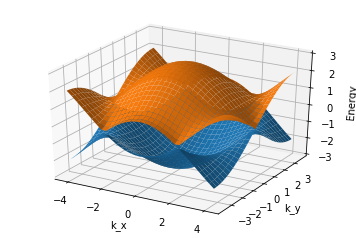

In [32]:
 lat = kwant.lattice.honeycomb(norbs=[1, 1])
sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))

bulk = kwant.Builder(sym)
bulk[ [lat.a(0, 0), lat.b(0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

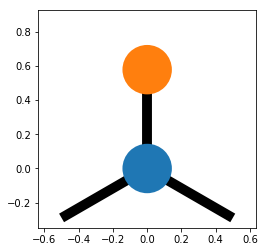

In [33]:
kwant.plot(bulk);

In [34]:
ham = builder_to_model(bulk)

In [35]:
hex_group_2D = qsymm.groups.hexagonal()
print(len(hex_group_2D))

48


In [36]:
sham = ham.tosympy(nsimplify=True)

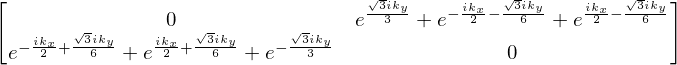

In [37]:
sham

In [38]:
mham = ham.tomodel(nsimplify=True)

In [39]:
mham

{e**(-I*k_x/2 - sqrt(3)*I*k_y/6):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

e**(sqrt(3)*I*k_y/3):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

e**(I*k_x/2 - sqrt(3)*I*k_y/6):
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]],

e**(I*k_x/2 + sqrt(3)*I*k_y/6):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

e**(-sqrt(3)*I*k_y/3):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

e**(-I*k_x/2 + sqrt(3)*I*k_y/6):
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]],

}

In [ ]:
 sg, cg = qsymm.symmetries(ham, hex_group_2D)
print(len(sg))
print(set(sg) == qsymm.groups.hexagonal())
print(cg)

# 6-orbital model of bulk SnTe

Model that includes spinful p-orbitals on both sublattices, 12 bands in total. Includes onsite SOC and $pp\sigma$ hoppings

In [ ]:
def SnTe_6orb(second_neighbor=True):
    """Make bulk 6-band model of SnTe from https://arxiv.org/pdf/1202.1003.pdf

    second_neighbor: bool (default True)
        Whether to include second neighbor hopping.
    """
    sigmas = qsymm.groups.spin_matrices(1/2)
    L = qsymm.groups.L_matrices(d=3, l=1)
    L_dot_S = np.sum([np.kron(sigmas[i], L[i]) for i in range(3)], axis=0)

    def onsite(site, m1, m2, lam1, lam2):
        m = np.array([m1, m2])
        lam = np.array([lam1, lam2])
        # choose onsite terms based on which sublattice
        a = np.sum(site.tag) % 2
        os = m[a] * np.eye(6)
        # L dot S onsite SoC
        spinorb = lam[a] * L_dot_S
        # x, y, z = site.pos
        os = os + spinorb
        return os

    def hopping(site1, site2, t11, t12, t22):
        t = np.array([[t11, t12], [t12, t22]])
        # which sublattice
        a = np.sum(site1.tag) % 2
        b = np.sum(site2.tag) % 2
        d = site1.tag - site2.tag
        # ppsigma bonding
        dtd = np.kron(np.eye(2), np.outer(d, d)/np.dot(d, d))
        # Use the appropriate hopping depending on sublattices
        hop = t[a, b] * dtd
        return hop

    # Cubic rocksalt structure with FCC symmetry
    lat = kwant.lattice.general(np.eye(3), norbs=6)
    # Default translation vectors of FCC structure
    translations = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, 0, 1], [0, 1, 1])
    syst = kwant.Builder(symmetry=translations)

    # Populate the builder using the cubic lattice sites
    # Two sublattices
    syst[lat(0, 0, 0)] = onsite
    syst[lat(0, 0, 1)] = onsite

    # First and second neighbor hoppings
    syst[lat.neighbors(1)] = hopping
    if second_neighbor:
        syst[lat.neighbors(2)] = hopping

    return syst

In [ ]:
syst = SnTe_6orb(second_neighbor=True)
SnTe_model = builder_to_model(syst)

Find symmetry group, it is full cubic $\times$ TR

In [ ]:
sg, cs = qsymm.symmetries(SnTe_model, candidates=qsymm.groups.cubic(), prettify=True)
print(len(sg), len(cs))

Check the symmetry without second neighbor hoppings

In [ ]:
syst2 = SnTe_6orb(second_neighbor=False)
SnTe_model2 = builder_to_model(syst2)

We find an extra unphysical spin conservation

In [ ]:
sg2, cs2 = qsymm.symmetries(SnTe_model2, candidates=qsymm.groups.cubic(), prettify=True)
print(len(sg2), len(cs2))

In [ ]:
cs2

# Wire with chiral symmetry

Kwant is used to generate the tight-binding model for a finite cross section wire

In [ ]:
import wire.funcs as funcs

Define symmetry candidates, in 1D the only nontrivial space-group element is inversion, besides add both TR and PH.

The $\mathbf{k\cdot p}$ Hamiltonian is discretized with a lattice constant of $a = 10$ nm. The wire and shell diameter of $r_1 = 15$ nm, $r_2 = 30$ nm used here allow the calculation in about 30 seconds, the example shown in the paper uses $r_1 = 25$ nm, $r_2 = 40$ nm and takes about 10 minutes.

The electric field is in the $z$ direction all along.

In [ ]:
candidates = {qsymm.PointGroupElement(np.eye(1), True, False, None),
              qsymm.PointGroupElement(np.eye(1), False, True, None),
              qsymm.PointGroupElement(-np.eye(1), False, False, None)
             }
candidates = qsymm.groups.generate_group(candidates)
len(candidates)

r1=15
r2=30
Vz = lambda *pos: pos[2]
color = lambda site: ('w' if (np.dot(site.pos, site.pos)) < r1**2 else 'r')

Make system with mirror symmetry and magnetic field in $x$ direction.

In [ ]:
syst_pars = dict(a=10, angle=0, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The system has the full 8-element symmetry group.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group still contains an effective time-reversal symmetry $M_y T$

In [ ]:
%time symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $y$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0.1, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group only contains $C_{2z} T$, which doesn't prevent band-tilting.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Move shell such that it breaks $M_y$

In [ ]:
syst_pars = dict(a=10, angle=45, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

Field only along the wire.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

Mirror symmetry $M_x$ is preserved.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

All symmetry is broken except for particle-hole.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]